# **Machine learning & Big Data Assignment**

**Package Installation**

In [39]:
# ! pip install  pycountry pandas
# ! pip install  plotly
# ! pip install  pyspark
# ! pip install  seaborn
# ! pip install  datetime


**Libraries importation**

In [40]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import pandas as pd
import numpy as np
import time
import pycountry
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))



ss = SparkSession.builder\
     .master("local")\
        .appName("test")\
         .config("spark.sql.legacy.timeParserPolicy", "LEGACY")\
            .getOrCreate()


In [41]:
Debute = time.time()

In [42]:
ss

In [43]:
# file location 
path = 'data\covid_table.csv'
# CSV file characteristics
infer_schema = "true"
first_row_header = "true"
delimiter = ","

# Read the data from a CSV file
table = ss.read.option("inferSchema" , infer_schema) \
               .option("header",first_row_header) \
               .option("sep" , delimiter) \
               .csv(path)


# clean imported data 
df = table.dropDuplicates(['Country/Region','Province/State','Lat','Long']) 


In [44]:
"""
Since the date format in the original dataframe is sometimes;
"MM/DD/YY" and sometimes "MM/DD/YYYY", we need to convert all 
the dates to the same format "MM/DD/YY"
"""

# Define the new column names and data types
new_column_names = [
    "Province/State",  # String
    "Country/Region",  # String
    "lat",             # Double
    "Long",            # Double
] + [col(date).cast(IntegerType()).alias(date) for date in df.columns[4:]]

# Rename the columns and cast data types
df = df.select(*new_column_names)
# Replace NaN values in "Province/State" with "no state"
df = df.na.fill("no state", subset=["Province/State"])

In [45]:
"""This block of code was meant to be used to create a csv file 
    which has all the countries of the world based on the pycountry library

   # Generating a list of country names using pycountry library
       countries = [country.name for country in pycountry.countries]

   # Creating a DataFrame and saving it as a CSV file
        Countries = pd.DataFrame(countries, columns=["Countries"])

   Countries .to_csv('data/Countries.csv', index=False)"""

'This block of code was meant to be used to create a csv file \n    which has all the countries of the world based on the pycountry library\n\n   # Generating a list of country names using pycountry library\n       countries = [country.name for country in pycountry.countries]\n\n   # Creating a DataFrame and saving it as a CSV file\n        Countries = pd.DataFrame(countries, columns=["Countries"])\n\n   Countries .to_csv(\'data/Countries.csv\', index=False)'

In [46]:

# Import the world map  Countries  into a DataFrame in pyspark
Countries = ss.read.csv('data/Countries.csv', header=True, inferSchema=True)

# Select distinct country names from your dataset
df_countries = df.select("Country/Region").distinct()

# Select distinct country names from the world map data
world_countries = Countries.select("Countries").distinct()


# we will use "Left anti" join to return rows from our DataFrame that doesn't represent a country 
Weird_countries = df_countries.join(world_countries, df_countries["Country/Region"] == world_countries["Countries"], "left_anti")

# we will display the mismatched countries
Weird_countries.show()


+--------------------+
|      Country/Region|
+--------------------+
|              Russia|
|               Burma|
|         Korea South|
|              Kosovo|
|          MS Zaandam|
|             Bolivia|
|    Congo (Kinshasa)|
|                Iran|
|                  US|
|                Laos|
|           Venezuela|
|            Holy See|
|             Taiwan*|
|       Cote d'Ivoire|
|Summer Olympics 2020|
|               Syria|
|         Korea North|
| Congo (Brazzaville)|
|              Brunei|
|  West Bank and Gaza|
+--------------------+
only showing top 20 rows



In [47]:
# Weird_countries.write.csv('weird_countries.csv', header=True, mode='overwrite')

In [48]:
# Now we are going to create a dictionary that contains the mismatched countries and their correct names
Corrected_country= {
    'US': 'United States of America',
    'Burma': 'Myanmar',
    'Korea North': 'North Korea',
    'Korea South': 'South Korea',
    'Kosovo': 'Republic of Kosovo',
    'Congo(Brazzaville)': 'Republic of the Congo',
    'Congo(Kinshasa)': 'Democratic Republic of the Congo',
    'Laos': "Lao People's Democratic Republic",
    'Venezuela': 'Venezuela (Bolivarian Republic)',
    'Holy See': 'Holy See (Vatican City State)',
    'Taiwan*': 'Taiwan',
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Syria': 'Syrian Arab Republic',
    'Brunei': 'Brunei Darussalam',
    'West Bank and Gaza':'Palestine',
    'Tanazania': 'United Republic of Tanzania',
    'Moldova': 'Republic of Moldova',
    'Vietnam': 'Viet Nam',
    'Russia': 'Russian Federation',
    'São Tomé and Príncipe': 'Sao Tome and Principe',
    
}


# Now we will replace the mismatched countries with the correct ones
df = df.replace(Corrected_country, subset=["Country/Region"])
""" df.filter((df["Country/Region"] == "United States of America") | 
          (df["Country/Region"] == "Taiwan")| 
          (df["Country/Region"] == "Sao Tome and Principe")|
          (df["Country/Region"] == "Diamond Princess")|
          (df["Country/Region"] == "Palestine")).show()"""


' df.filter((df["Country/Region"] == "United States of America") | \n          (df["Country/Region"] == "Taiwan")| \n          (df["Country/Region"] == "Sao Tome and Principe")|\n          (df["Country/Region"] == "Diamond Princess")|\n          (df["Country/Region"] == "Palestine")).show()'

In [49]:
# Now we are going to create a list that contains the elements in the "Country/Region" not corresponding to contries

None_contries = ['MS Zaandam', 'Diamond Princess', 'Summer Olympics 2020', 'Winter Olympics 2022']

df = df.filter(~df['Country/Region'].isin(None_contries))
df.show()
# df.write.csv('data/Cleaned_df.csv', header=True, mode='overwrite')


+--------------------+--------------+---------+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--

In [50]:
# calculate the time it took to run the code
Cleaning_data_time = time.time() - Debute
# print the duration
print("Cleaning_data_time: ", Cleaning_data_time , "seconds")

Cleaning_data_time:  36.61188864707947 seconds


# Task 1


**IN this code section we are trying to calculate the mean number of confirmed cases daily for each month in the dataset, For each country**


In a first place, we will try to group the Dataframe Based on the "Country/Region" category ,For the countries possessing multiple provinces/states we will aggregate all the cases into a single row , representing the total cases for the entire country .

In [51]:
# We start by Grouping the data by "Country/Region"
group_df = df.groupBy("Country/Region")

# We store the date columns in a list
date_columns = df.columns[4:]

""" We iterate over the columns starting from the 5th column (index 4)
    and then we apply an aggregation function to each column that has 
    the same "country/region" Value 
"""
aggregated_columns = [sum(col(date)).alias(date) for date in date_columns]

# We Apply the aggregation to the grouped DataFrame
sum_df = group_df.agg(*aggregated_columns)


After grouping the Dataframe by "Cuntry/Region" in the DataFrame "sum_df" .In a second place , we will try to calculate the mean number of confirmed cases daily for each month and we will group them by "Country/Region" and "Date" .

In [52]:
""" since the Dataframe sum_df has a wide format and this format is not compatible
    with the opertions we want to perform on the data , we will need to transform
    the DataFrame from wide to long format 
"""

# We will extract the date columns from the DataFrame sum_df
date_columns = sum_df.columns[1:]  

"""the following  code is constructing a dynamic stack expression that we will use
   for pivoting date columns in sum-df into a date-wise row format, where 
   each row represents a date and its associated case count.
"""

stack_df = "stack({0}, {1}) as (Date, Cases)".format(
    len(date_columns),', '.join(["'{0}', `{0}`".format(c) for c in date_columns])
)

"""We will proceed to the final transpormation by using the function selectExpr
    which will allow us to select the columns we want to keep -"Country/Region"- and 
    apply the stack expression to the date columns
 """
# we diddn't use the function select because we want to keep the column "Country/Region"
long_df = sum_df.selectExpr("`Country/Region`", stack_df)

# We should Convert the 'Date' string we got from the stack function to an actual date type
long_df = long_df.withColumn("Date", to_date(col("Date"), "MM/dd/yy"))

# We will add two new columns to the DataFrame long_df where to specify the month 
# and the last day of each month because we will need them later
long_df = long_df .withColumn("YearMonth", date_format(col("Date"), "yyyy-MM")) \
         .withColumn("MonthLastDay", last_day(col("Date")))\
         .withColumn("MonthFirstDay", expr("to_date(concat(year(Date), '-', month(Date), '-01'))"))

# We will use window functions to get the last day of each month
windowSpecLast = Window.partitionBy("Country/Region", "YearMonth").orderBy(col("Date").desc())
last_day_cases = long_df.withColumn("rank", rank().over(windowSpecLast)) \
                    .filter(col("rank") == 1).select("Country/Region", "YearMonth", col("Cases").alias("LastDayCases"), "MonthLastDay")


# We will use window functions to get the First day of each month
windowSpecFirst = Window.partitionBy("Country/Region", "YearMonth").orderBy(col("Date"))
first_day_cases = long_df.withColumn("rank", rank().over(windowSpecFirst)) \
                     .filter(col("rank") == 1).select("Country/Region", "YearMonth", col("Cases").alias("FirstDayCases"), "MonthFirstDay")
# Join the datasets
combined_cases = last_day_cases.join(first_day_cases, ["Country/Region", "YearMonth"])
#combined_cases.show()
# we will Calculate the average cases per day for each month and store them in 
monthly_data = combined_cases.withColumn("DaysInMonth", dayofmonth(col("MonthLastDay"))) \
                              .select("Country/Region", "YearMonth", ((col("LastDayCases") - col("FirstDayCases")) / col("DaysInMonth")).alias("AverageDailyCases"))


In [53]:
# Pivot the DataFrame to get one column for each month with the average cases per day
Task1_df = monthly_data.groupBy("`Country/Region`").pivot("YearMonth").agg(first("AverageDailyCases"))

Task1_df.show(10,truncate=False)

+-------------------+------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|Country/Region     |2020-01           |2020-02             |2020-03            |2020-04           |2020-05            |2020-06           |2020-07           |2020-08           |2020-09            |2020-10           |2020-11       

In [54]:
# Task1_df.write.csv('data/Task1_df.csv', header=True, mode='overwrite')
# calculate the time it took to run the code of Task1
Task1_time = time.time() - Cleaning_data_time- Debute
# print the duration
print("Task1_time: ", Task1_time , "seconds")

Task1_time:  53.03629183769226 seconds


# Task 2

**In this task we are going to calculate the mean, standard deviation, minimum and maximum of the number of confirmed cases daily for each week , to do so we will break down this task into smaller, more manageable steps**


Step 1 : we will need to transform the Dataframe from wide to long format .


In [55]:
# Replace Unknown values with None
df2 = df.na.replace("Unknown", None)

# Selecting non-date columns and creating an array of date columns
Head = ['Province/State', 'Country/Region', 'lat', 'Long']
date_columns = [col for col in df2.columns if col not in Head]

# Creating an array of date columns and their corresponding values
array_cols = [struct(lit(c).alias("Date"), col(c).alias("Cases")) for c in date_columns]
stacked_cols = explode(array(array_cols)).alias("stacked_cols")

# Transforming the DataFrame from wide to long format 
long_df2 = df2.select(*Head, stacked_cols)\
             .select(*Head, "stacked_cols.Date", "stacked_cols.Cases")

""" Creating a new column 'State/Region' and filling it with the values of 'Province/State' column 
 if the value is not 'no state' and with the values of 'Country/Region' column otherwise"""

long_df2 = long_df2.withColumn('State/Region', 
                               when(col('Province/State') != 'no state', col('Province/State'))
                               .otherwise(col('Country/Region')))

# Selecting the required columns and Then converting 'Date' to a proper date format
long_df2 = long_df2.select('State/Region', 'Date', 'Cases')
long_df2 = long_df2.withColumn('Date', to_date(col('Date'), 'MM/dd/yy'))



Step 2 : we will try  to evaluate the trend of the dailyincreases of confirmed cases through  the slope of the regression line that approximates the trend of the daily increments .

In [56]:
# We will sort long_df2 first by the "State/Region" column and then by the "Date" column
long_df2 = long_df2.orderBy("State/Region", "Date")

# we Define a window  partitioned by 'State/Region' and ordered by 'Date'
window = Window.partitionBy("State/Region").orderBy("Date")

"""We will add new column "Day_Index" to long_df2,
     representing the sequential day number within each "State/Region" 
          starting from 0"""
long_df2 = long_df2.withColumn("Day_Index", row_number().over(window) - 1)

# we calulate the daily cases based on the fact that te data is cumulative
window_lag = window.rowsBetween(-1, 0)
long_df2 = long_df2.withColumn("Previous_Cases", lag("Cases").over(window))
long_df2 = long_df2.withColumn("Daily_Cases", col("Cases") - col("Previous_Cases"))

# Filter out rows where Daily_Cases is negative
long_df2 = long_df2.filter(col("Daily_Cases") >= 0)


# Calculate Aggregations preparing  for Linear Regression
aggregates = long_df2.groupBy("State/Region").agg(
    count("Day_Index").alias("n"),
    sum(col("Day_Index") * col("Daily_Cases")).alias("sum_xy"),
    sum("Day_Index").alias("sum_x"),
    sum("Daily_Cases").alias("sum_y"),
    sum(col("Day_Index") * col("Day_Index")).alias("sum_x2")
)



"""we will calculate the slope of the linear regression line for each "State/Region"  
         using the formula for the slope in a linear regression."""

slope_df = aggregates.withColumn("Trendline Coefficient", 
                                 (col("n") * col("sum_xy") - col("sum_x") * col("sum_y")) / 
                                 (col("n") * col("sum_x2") - col("sum_x") * col("sum_x"))
                                )



Step 3 : we will rank "State/Region" based on the slope and selects the top 100 most affected states/regions.

In [57]:
# we will sort the DataFrame by the trendline coefficient value in descending order
ranked_df = slope_df.orderBy(col("Trendline Coefficient").desc())
#ranked_df.show()
#ranked_df.write.format("csv").option("header", "true").mode("overwrite").save("ranked_df.csv")

# Selecting  the top 100 most affected states/regions.
Most_Affected_States = ranked_df.select("State/Region", "Trendline Coefficient").orderBy(col("Trendline Coefficient").desc()).limit(100)

# Now perform the join
Joined_long_df = long_df2.join(Most_Affected_States, on="State/Region", how="inner")
Joined_long_df = Joined_long_df.orderBy(col("Trendline Coefficient").desc())
# Joined_long_df.filter(col("State/Region") == "Queensland").show()
Joined_long_df = Joined_long_df.drop("Day_Index")



In [58]:
# Joined_long_df.write.format("csv").option("header", "true").mode("overwrite").save("data/Countries_Trendline.csv")

Step 4 :we will add new column "Continent" to the Dataframe determine to which continent the State/Region  belongs.

In [59]:

"""we will start by Defining  a mapping from "State/Region" to "Continent" 
      using when().otherwise() statements for each continent"""
continent_mapping = (
    when(col("State/Region").isin(['Barbados','United States of America','Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
                                     'Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon']), 'North America'
    ).when(col("State/Region").isin(['New Zealand','Australian Capital Territory', 'New South Wales', 'Northern Territory', 'Queensland', 'South Australia', 'Tasmania', 'Victoria', 'Western Australia']), 'Australia'
    ).when(col("State/Region").isin(['Republic of Kosovo','Albania','North Macedonia','Bosnia and Herzegovina','Republic of Moldova','Belarus','Montenegro','Gibraltar','Guernsey','Isle of Man','Jersey','Montserrat','Pitcairn Islands','Saint Barthelemy','Saint Pierre and Miquelon','French Guiana','Martinique','Mayotte' ,'St Martin','Wallis and Futuna','New Caledonia','French Polynesia','Guadeloupe','French Guiana','Mayotte','Martinique','Reunion','Serbia','Czechia','Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom','Ukraine']), 'Europe'
    ).when(col("State/Region").isin(['Burma','West Bank and Gaza','Micronesia','Guizhou','Hainan','Hebei','Heilongjiang','Henan','Hong Kong','Hubei','Hunan','Inner Mongolia','Jiangsu','Jiangxi','Jilin','Liaoning','Macau','Ningxia','Qinghai','Shaanxi','Shandong','Shanghai','Shanxi','Sichuan','Tianjin','Tibet','Xinjiang','Yunnan','Zhejiang','Anhui','Beijing','French Guiana','Chongqing','Fujian' ,'Gansu','Guangdong','Hong Kong','Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan',"Brunei Darussalam", 'Cambodia', 'China', 'Georgia', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'South Korea', 'Oman', 'Pakistan', 'Palestine', 'Philippines', 'Qatar', 'Russian Federation', 'Saudi Arabia', 'Singapore', 'Korea South', 'Sri Lanka', 'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Viet Nam', 'Yemen']), 'Asia'
    ).when(col("State/Region").isin(['Congo (Kinshasa)','Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Democratic Republic of the Congo', 'Republic of the Congo', 'Cote d Ivoire', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']), 'Africa'
    ).when(col("State/Region").isin(['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto Rico', 'Trinidad and Tobago', 'United States Virgin Islands', 'Uruguay', 'Venezuela (Bolivarian Republic)']), 'South America'
    ).otherwise('Unknown')
)

# We will then apply this mapping to our dataframe to create a new column "Continent"
Joined_long_df = Joined_long_df.withColumn("Continent", continent_mapping)
Joined_long_df = Joined_long_df.select("Continent", *[col for col in Joined_long_df.columns if col != "Continent"])


Step 5 :For each continent we will calculate the mean, standard deviation, minimum and maximum of thenumber of confirmed cases daily for each week.

In [60]:
# we start by extracting week number from 'Date' column to defien a new column 'Week'
Joined_long_df = Joined_long_df.withColumn("Year", year("Date"))
Joined_long_df = Joined_long_df.withColumn("Week", weekofyear("Date"))


# we will Group data by 'Continent' and 'Week', and calculate the metrics
result_df = Joined_long_df.groupBy("Continent", "Year","Week").agg(
    mean("Daily_Cases").alias("Mean_Cases"),
    stddev("Daily_Cases").alias("Stddev_Cases"),
    min("Daily_Cases").alias("Min_Cases"),
    max("Daily_Cases").alias("Max_Cases")
)

# we Sort the DataFrame by 'Continent' , 'year' and  'Week'
Task2_df = result_df.orderBy("Continent", "Year","Week")

# count the number of rows
num_rows = Task2_df.count()

# count the number of columns
num_cols = len(Task2_df.columns)

# print "Number of rows" , "Number of columns"  
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Show the result
Task2_df.show(10, truncate=False)

Number of rows: 996
Number of columns: 7
+---------+----+----+-------------------+------------------+---------+---------+
|Continent|Year|Week|Mean_Cases         |Stddev_Cases      |Min_Cases|Max_Cases|
+---------+----+----+-------------------+------------------+---------+---------+
|Africa   |2020|4   |0.0                |0.0               |0        |0        |
|Africa   |2020|5   |0.0                |0.0               |0        |0        |
|Africa   |2020|6   |0.0                |0.0               |0        |0        |
|Africa   |2020|7   |0.0                |0.0               |0        |0        |
|Africa   |2020|8   |0.0                |0.0               |0        |0        |
|Africa   |2020|9   |0.0                |0.0               |0        |0        |
|Africa   |2020|10  |0.07142857142857142|0.262265264156481 |0        |1        |
|Africa   |2020|11  |0.5714285714285714 |1.8141128109919984|0        |9        |
|Africa   |2020|12  |2.642857142857143  |4.279272054002797 |0       

In [61]:
# Task2_df.write.format("csv").option("header", "true").mode("overwrite").save("Task2_df.csv")
# calculate the time it took to run the code of task2
Task2_time = time.time() - Task1_time - Cleaning_data_time- Debute
# print the duration
print("Task2_time: ", Task2_time , "seconds")

Task2_time:  70.04756784439087 seconds


# Task 3

**In this task we are going to calculate the most affected states for each month of the Dataset according to the trendline coefficient, And for each month in the dataset we should apply the clustering algorithm K-means and determine the states  that are part of each cluster , to do so we will break down this task into smaller, more manageable steps**

Step 1 : we will start by importing the dataframe in the its long formate that we have previously achieved in Task 1

In [62]:
# we will start by importing the previous DataFrame in the long format 
file_path = "data/long_df2.csv"
data = pd.read_csv(file_path)

# we convert the 'Date' column to datetime and  then extract year and month
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# we sort the data by 'State/Region', 'Year' and 'Month' 
grouped_data = data.groupby(['State/Region', 'Year', 'Month'])

# Now, proceed with the aggregation
Organized_data = grouped_data.agg({'Daily_Cases': 'sum'}).reset_index()
Organized_data = Organized_data.rename(columns={'Daily_Cases': 'Cases'})
# Organized_data.head(10)


Step 2 : we will analyze trends in data  over time for different like states or regions  and identifying the top 50 groups each month based on their trendline value .

In [63]:
# define a function to calculate the trendline coefficient for a given x, y series
def trendline_coef(x, y):
    linear_coeffs = np.polyfit(x, y, 1)
    return linear_coeffs[0]  # Coefficient of the linear term

# define an other function to apply trendline_coef() to each "State/Region" group
def state_trendline(group):
    # we Generate an array of X values from 0 to the length of the group
    X = np.arange(len(group))

    # We Use the 'Cases' column as Y values
    Y = group['Cases']

    # We Calculate the trendline coefficient using our function
    coefficient = trendline_coef(X, Y)

    return coefficient

# We then apply this function to each column in 'grouped_data' and reset the index
# The lambda function here is used to apply the custom function to each group
trendline_coefs = grouped_data.apply(lambda g: state_trendline(g)).reset_index()

# We then rename the column that contains the calculated coefficients for clarity
trendline_coefs.rename(columns={0: 'Trendline_Coefficient'}, inplace=True)


# Sorting and selecting the top 50 states/regions for each month
top_50_State = trendline_coefs.sort_values(by=['Year', 'Month', 'Trendline_Coefficient'], ascending=[True, True, False]) \
                                .groupby(['Year', 'Month']).head(50)

# top_50_State.head()

# top_50_State.to_csv('data/top_50_State.csv', index=False)

Step 3 :we will Implement the K-means clustering algorithm[1, 2], setting the number of clusters (K) to 4. Identify which states or regions  belong to each of these clusters. 

In [64]:
TOP50_STATE = ss.read.csv('data/top_50_State.csv' , header=True, inferSchema=True)

#   We will Combine "Year" and "Month" into a single "Year-Month" column
TOP50_STATE = TOP50_STATE.withColumn("Year-Month", concat_ws("-", TOP50_STATE.Year, TOP50_STATE.Month))

# We then Convert the 'Trendline_Coefficient' column to a vector column befor applying the KMeans algorithm
vec_assembler = VectorAssembler(inputCols=["Trendline_Coefficient"], outputCol="features")
TOP50_STATE_kmeans = vec_assembler.transform(TOP50_STATE)

# we group TOP50_STATE  by year and month and then  apply KMeans for each Month
k = 4  # Number of clusters
results_df = None

# Apply KMeans for each "Year-Month" group
unique_year_months = TOP50_STATE.select("Year-Month").distinct().collect()
for row in unique_year_months:
    year_month = row["Year-Month"]
    df_month = TOP50_STATE_kmeans.filter(col("Year-Month") == year_month)
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_month)

    # We will Predict the cluster for each data point
    predictions = model.transform(df_month)

    # Update the results DataFrame
    if results_df is None:
        results_df = predictions
    else:
        results_df = results_df.union(predictions)

# Sort the results DataFrame by "Year-Month" and "prediction"
results_df = results_df.orderBy("Year-Month", "prediction")

Task3_df = results_df.drop("Year", "Month", "features").select("State/Region", "Year-Month", "Trendline_Coefficient", "prediction")
Task3_df.show()

+--------------------+----------+---------------------+----------+
|        State/Region|Year-Month|Trendline_Coefficient|prediction|
+--------------------+----------+---------------------+----------+
|               Hubei|    2020-1|    709.8666666666664|         0|
|United Arab Emirates|    2020-1|   0.5999999999999999|         1|
|               Gansu|    2020-1|    3.866666666666666|         1|
|              Shanxi|    2020-1|    5.233333333333332|         1|
|             Tianjin|    2020-1|   3.7499999999999996|         1|
|               Jilin|    2020-1|   1.6499999999999997|         1|
|     New South Wales|    2020-1|   0.6166666666666665|         1|
|               Japan|    2020-1|   1.5333333333333328|         1|
|             Shaanxi|    2020-1|   10.266666666666664|         1|
|           Singapore|    2020-1|    1.333333333333333|         1|
|             Guangxi|    2020-1|    9.633333333333331|         1|
|           Hong Kong|    2020-1|   1.2333333333333332|       

In [65]:
# Task3_df.write.csv("data/Task3_df.csv", header=True)
# calculate the time it took to run the code of task3
Task3_time = time.time() - Task2_time - Task1_time - Cleaning_data_time- Debute
# print the duration
print("Task3_time: ", Task3_time , "seconds")

Task3_time:  43.39625954627991 seconds


# Visualization of The results 

**Import the required libraries To prepare for the visualization.**

In [66]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import geoplot as gplt
from matplotlib.colors import Normalize
import plotly.express as px

**Overall Visualization of The location of the Regions mentionned In the covid Dataframe**

Geographical Representation of The regions affected by COVID-19

C:\Users\yasser.elkarkouri\AppData\Local\Temp\ipykernel_11892\3733373292.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



<Figure size 500x300 with 0 Axes>

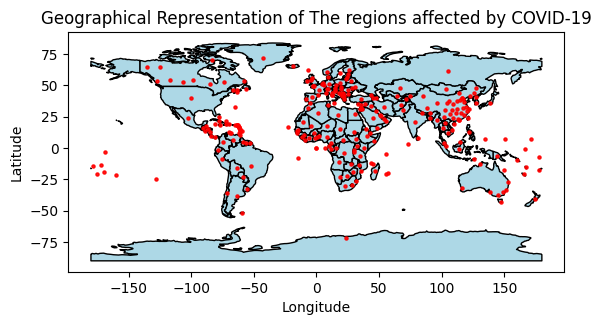

In [67]:

# Loading the dataset
V_data = pd.read_csv('data/Cleaned_df.csv')

# Define a function to plot the map Based on the "lat" and "long" columns of a DataFrame
def plot_map(DataFrame):

    # Plotting the world map
    plt.figure(figsize=(5, 3))
    world_Map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_Map.plot(color='lightblue', edgecolor='black')

    # Plotting the points based on latitude and longitude
    plt.scatter(DataFrame['Long'], DataFrame['lat'], color='red', alpha=0.9, marker='o', s=5)

    plt.title('Geographical Representation of The regions affected by COVID-19')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Apply the function to the our covid dataframe 
plot_map(V_data)


**Visualize the Results of the Task1**

we will try to define a function to plot a bar graph that evaluate daily average of COVID-19 cases each month over time for a chosen list of countries 

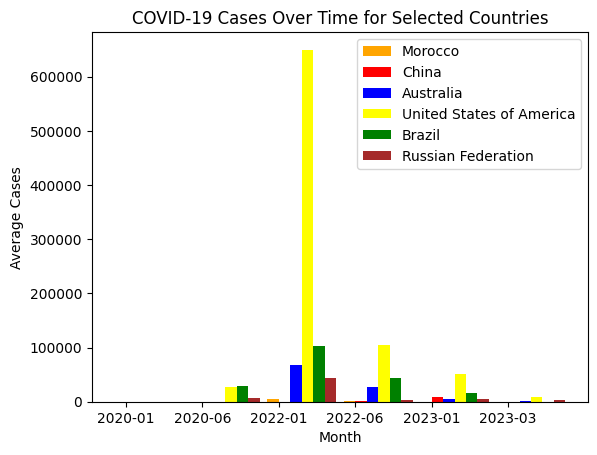

In [68]:
def plot_BarGraph(df, countries, dates, colors, xlabel, ylabel, title):
    bar_width = 0.15  # the width of each bar

    # Plot the average cases for each country in the list
    for idx, country in enumerate(countries):
        # Filter the data for the country and the specified dates
        country_data = df[(df['Country/Region'] == country) & (df['YearMonth'].isin(dates))]
        
        # Extract the average cases for the given dates for each country
        avg_cases = country_data['AverageDailyCases'].tolist()

        # Position of bars on x-axis
        bar_positions = np.arange(len(dates)) + idx * bar_width

        # Draw the bars for this country in the chart
        plt.bar(bar_positions, avg_cases, color=colors[idx], width=bar_width, label=country)

    # Add the provided labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Set the position of labels on the x-axis
    plt.xticks(np.arange(len(dates)) + bar_width / 2, dates)

    # Add a legend to the chart
    plt.legend()

    # Finally, display the chart
    plt.show()


# Adjusting the country names and colors as per the new request
countries = ["Morocco", "China", "Australia", "United States of America", "Brazil", "Russian Federation"]
colors = ["Orange", "Red", "Blue", "Yellow", "Green", "Brown"]
dates = ["2020-01", "2020-06", "2022-01", "2022-06", "2023-01", "2023-03"]
df_Task1_long = pd.read_csv('data/long_Task1_df.csv')
# Plotting the graph with the updated country list and colors
plot_BarGraph(df_Task1_long, countries, dates, colors, 'Month', 'Average Cases', 'COVID-19 Cases Over Time for Selected Countries')


we will try to plot a bar graph that evaluate daily average of COVID-19 cases each month over time for the given country

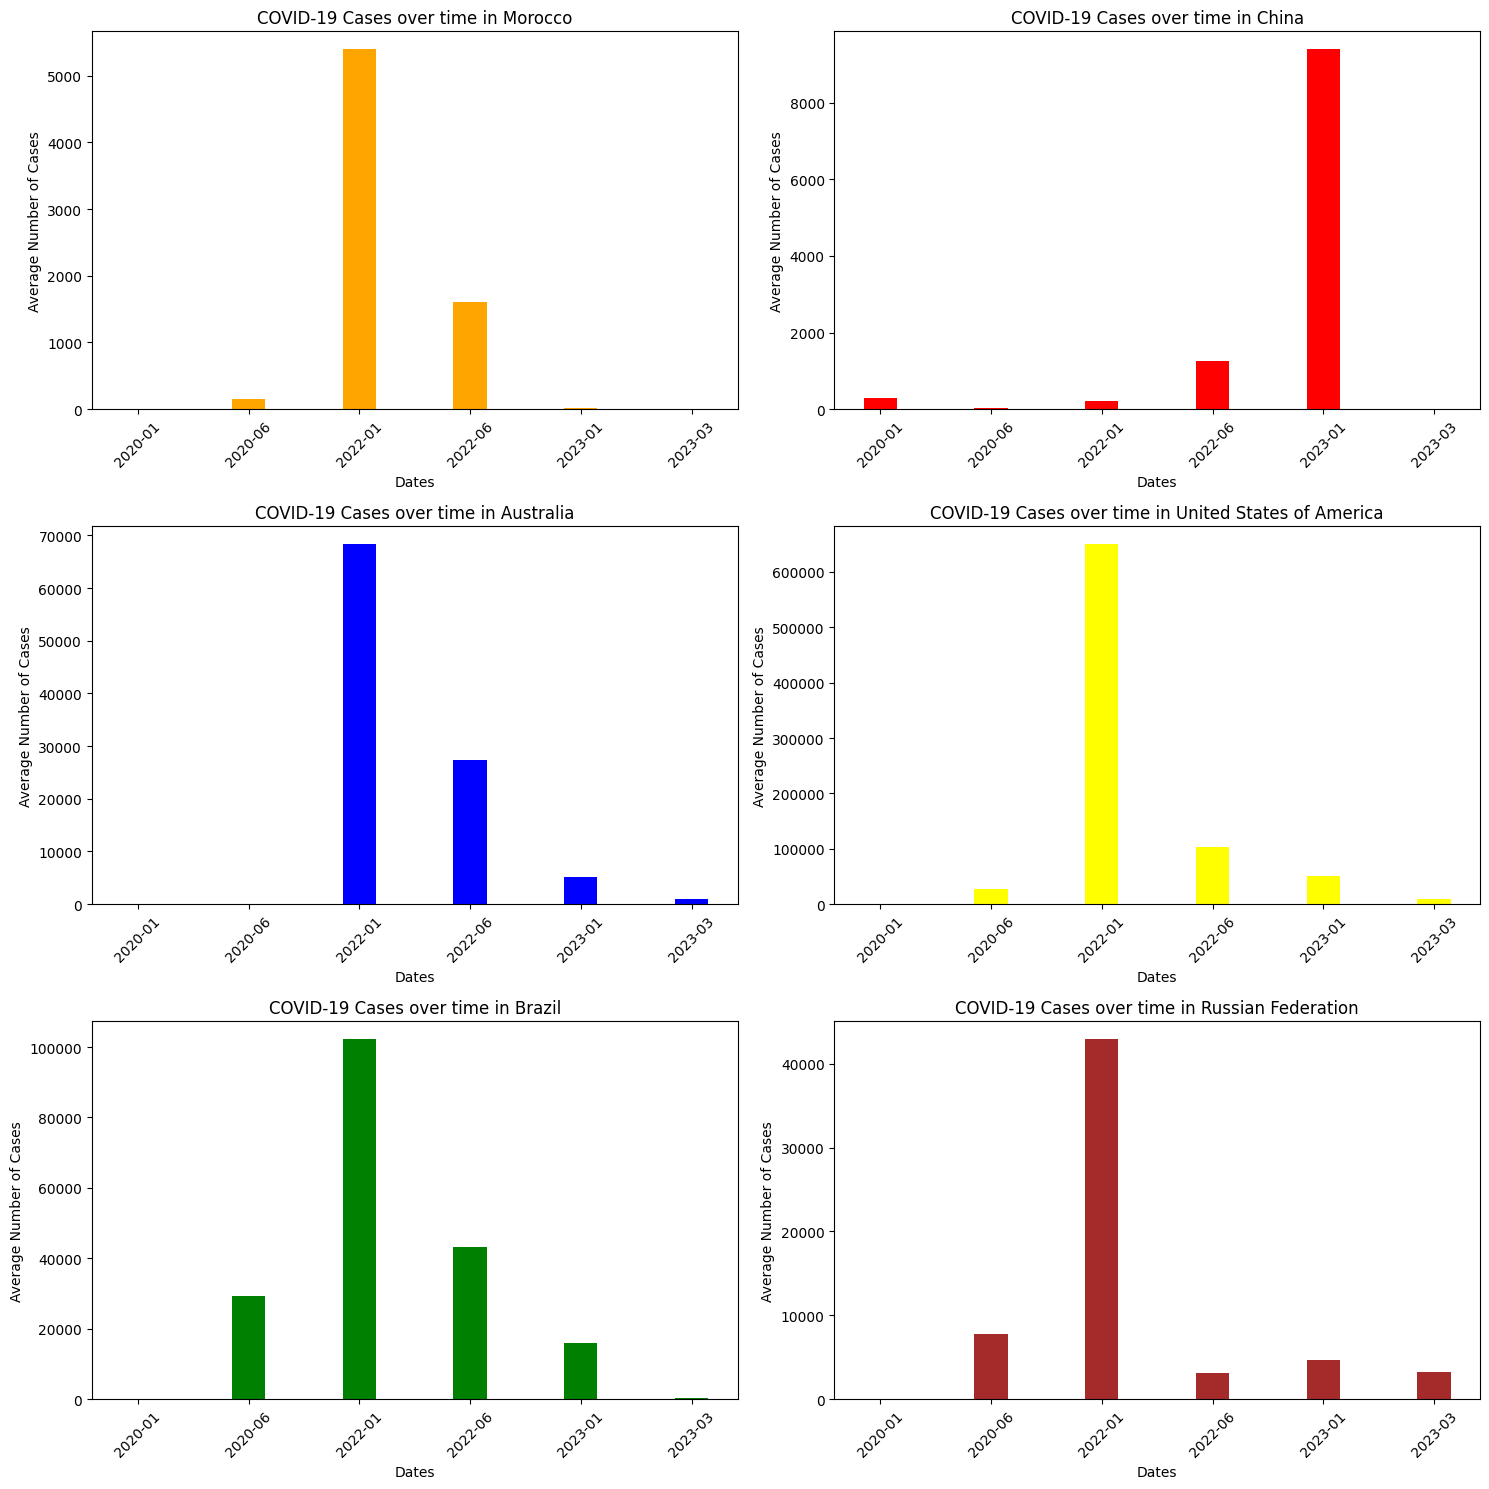

In [69]:
df_Task1 = pd.read_csv('data/Task1_df.csv')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  
axes = axes.flatten()  

for X, country, color in zip(axes, countries, colors):
    country_data = df_Task1[df_Task1['Country/Region'] == country][dates].mean()
    X.bar(dates, country_data, color=color,width= 0.3)
    X.set_title(f'COVID-19 Cases over time in {country}')
    X.set_xlabel('Dates')
    X.set_ylabel('Average Number of Cases')
    X.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Visualize the Results of the Task2**

we will try to write a program to evaluate daily average of COVID-19 cases each month for the top 100 "State/Region"

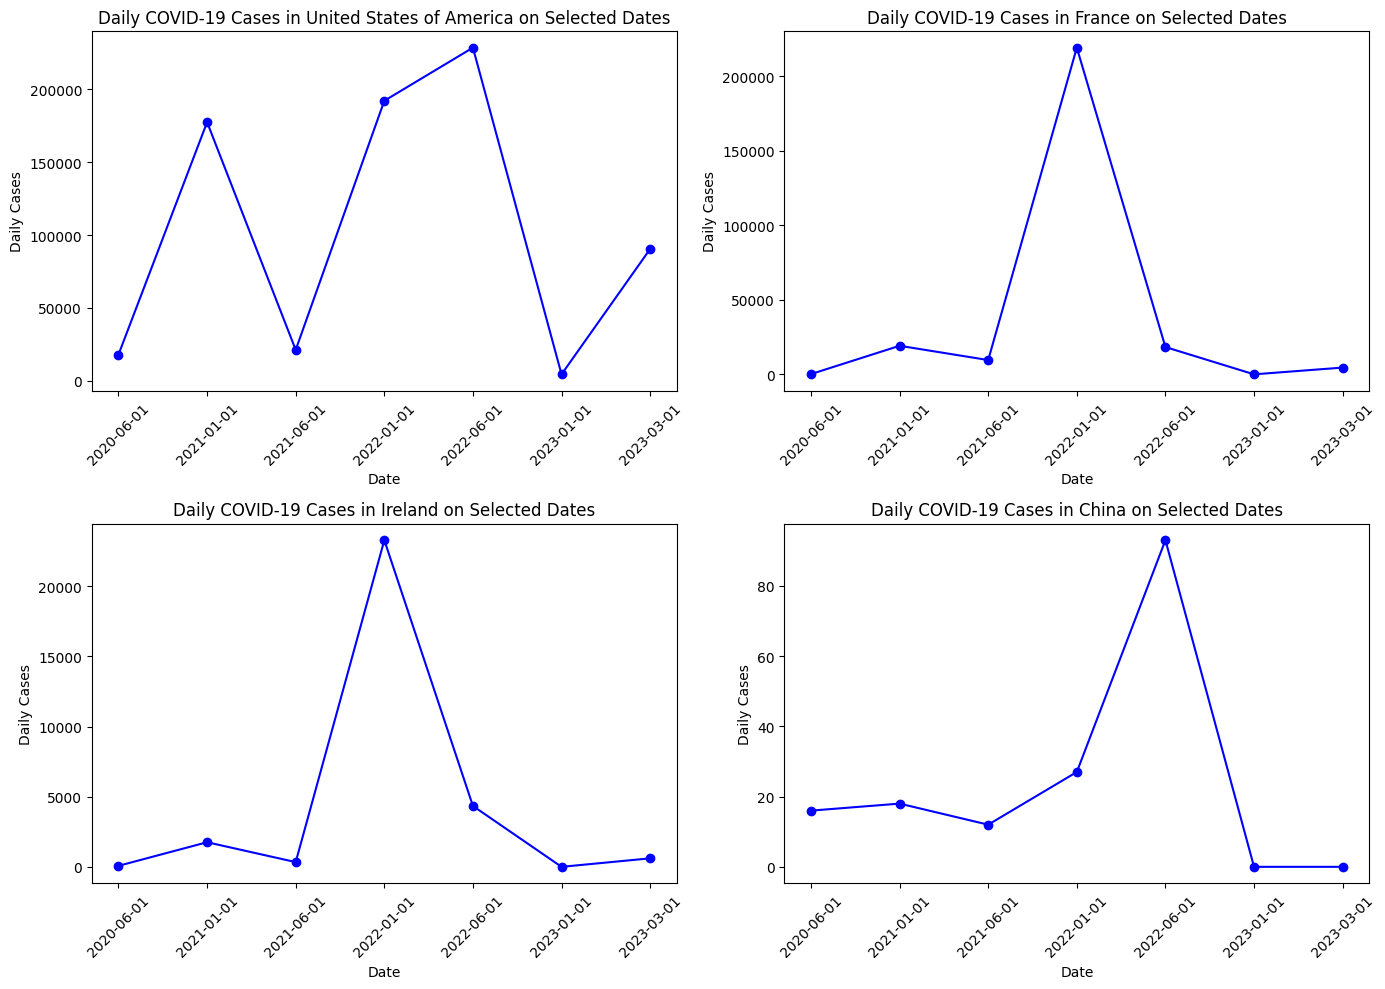

In [70]:
Top_100 = pd.read_csv('data/Countries_Trendline.csv')

# Select random dates from the list of dates and Countries from the list of "State/Region"
dates = ["2020-01-22", "2020-06-01", "2021-01-01", "2021-06-01", "2022-01-01", "2022-06-01", "2023-01-01", "2023-03-01"]
countries = ["United States of America", "France", "Ireland", "China"]

# Select the "State/Region" that matches the countries in the list and the dates in the list
filtered_data = Top_100[(Top_100['State/Region'].isin(countries)) & (Top_100['Date'].isin(dates))]

# Determine the layout of subplots based on the number of countries
Sub_Plots = len(countries) // 2 + len(countries) % 2
fig, axs = plt.subplots(Sub_Plots, 2, figsize=(14, 5 * Sub_Plots), squeeze=False)

# Plotting each country's data
for idx, country in enumerate(countries):
    axes = axs[idx // 2, idx % 2]
    country_data = filtered_data[filtered_data['State/Region'] == country].sort_values(by='Date')

    # Plotting with line
    axes.plot(country_data['Date'], country_data['Daily_Cases'], marker='o', linestyle='-', color='b')
    axes.set_title(f'Daily COVID-19 Cases in {country} on Selected Dates')
    axes.set_xlabel('Date')
    axes.set_ylabel('Daily Cases')
    axes.tick_params(axis='x', rotation=45)

# Adjusting layout
plt.tight_layout()
plt.show()


Now we are going to visualize the dataframe of the query 2 which listed the mean, standard deviation, minimum and maximum of thenumber of confirmed cases daily for each week for **Continents**

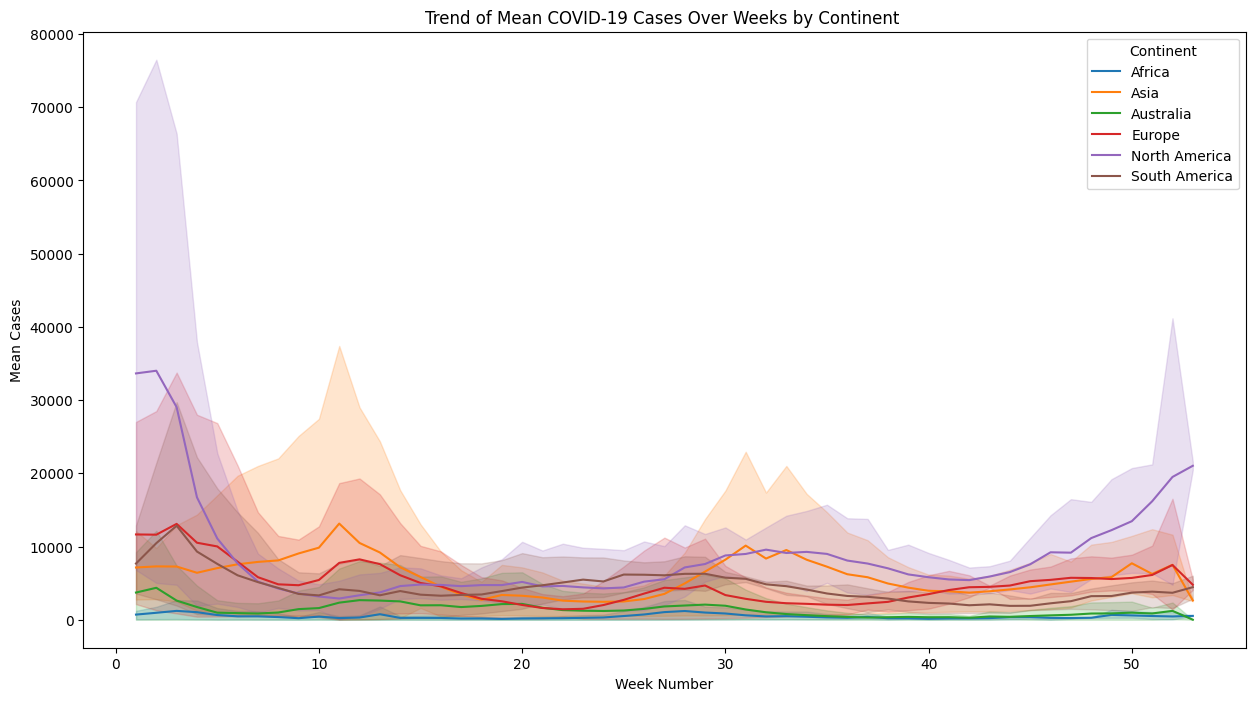

In [71]:
task2_df = pd.read_csv('data/Task2_df.csv')

# We will start by ploting a time line series for each continent
continents = task2_df['Continent'].unique()

plt.figure(figsize=(15, 8))
for continent in continents:
    continent_data = task2_df[task2_df['Continent'] == continent]
    sns.lineplot(data=continent_data, x='Week', y='Mean_Cases', label=continent)

plt.title('Trend of Mean COVID-19 Cases Over Weeks by Continent ')
plt.xlabel('Week Number')
plt.ylabel('Mean Cases')
plt.legend(title='Continent')
plt.show()

 We are going to plot a scatter plot for each continent to show the relationship between the mean and the standard deviation of Covid Cases .

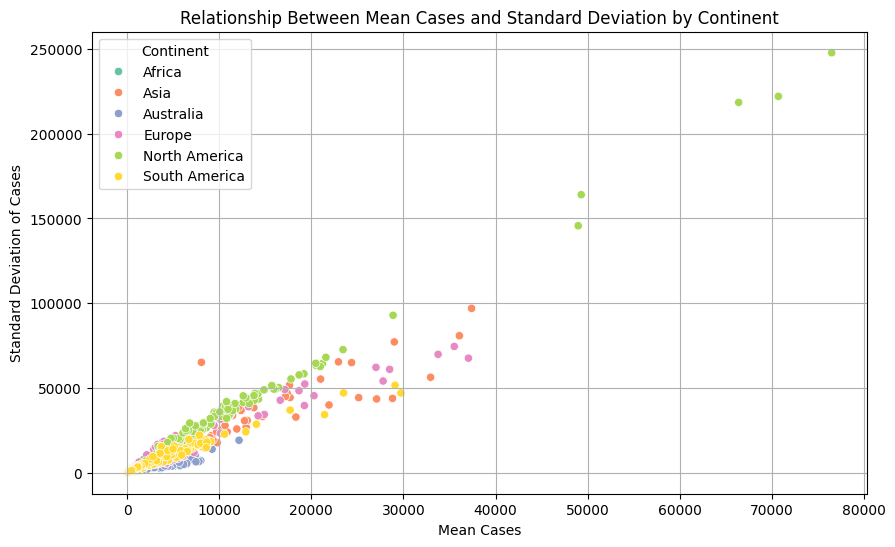

In [72]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=task2_df, x='Mean_Cases', y='Stddev_Cases', hue='Continent', palette='Set2', marker='o')
plt.title('Relationship Between Mean Cases and Standard Deviation by Continent')
plt.xlabel('Mean Cases')
plt.ylabel('Standard Deviation of Cases')
plt.legend(title='Continent')
plt.grid(True)
plt.show()

We ar going to plot two graph bars to compare the Min_Cases and the Max_Cases for the continents 

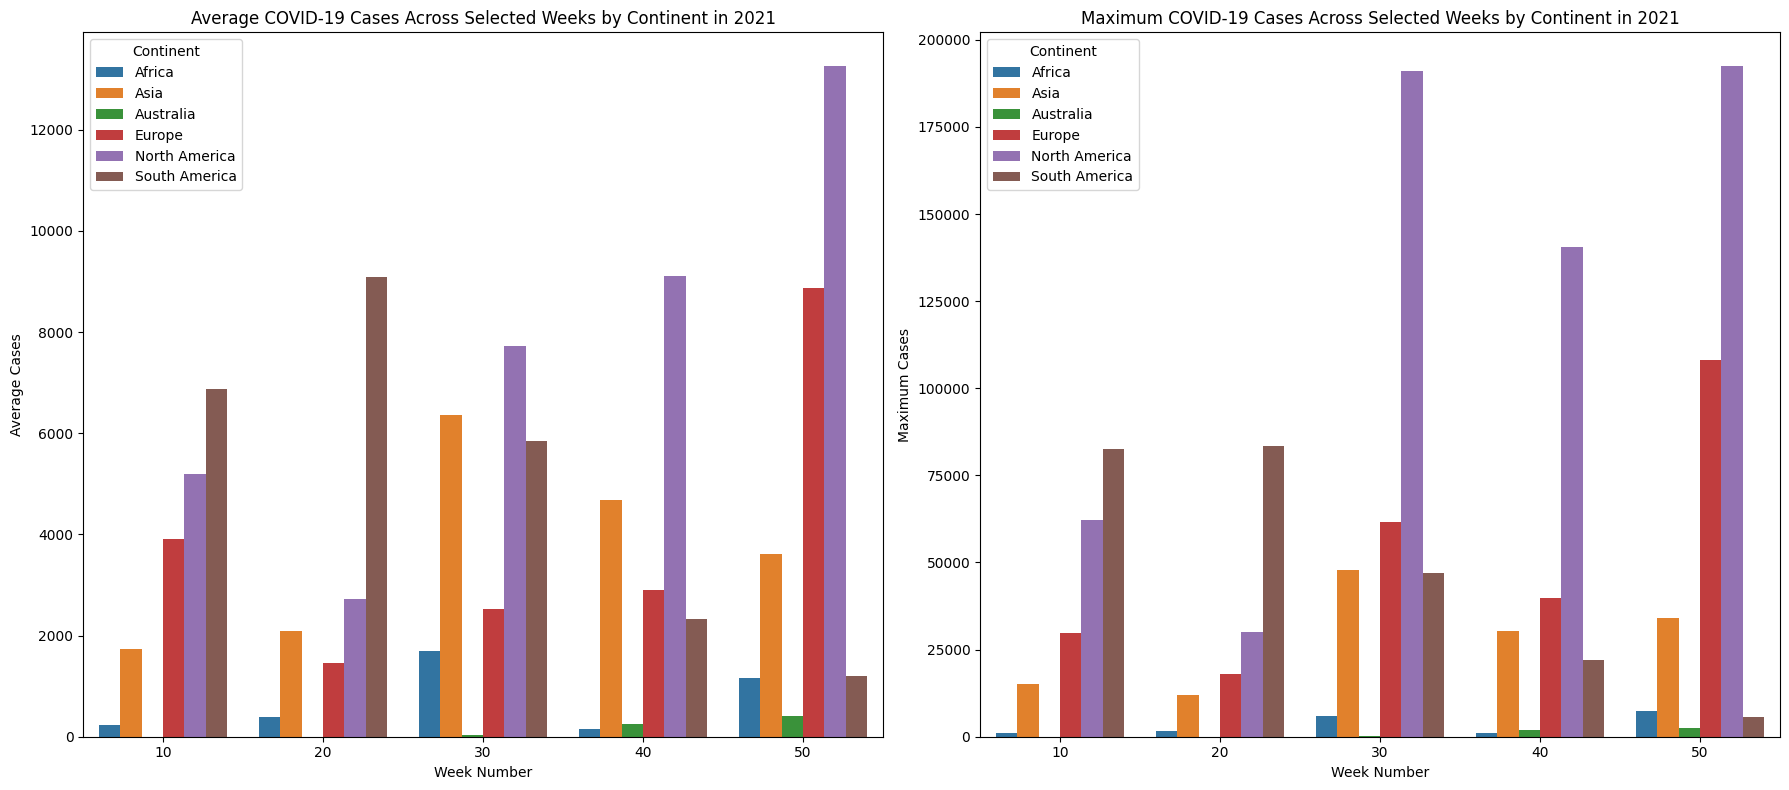

In [73]:
# Box Plot for Weekly Cases in the year 2020
Year_2021 = task2_df[task2_df['Year'] == 2021]

# Selecting a few weeks for demonstration
weeks = [10, 20, 30, 40, 50]
weeks_data = Year_2021[Year_2021['Week'].isin(weeks)]

# Bar Graphs for Min and Max Cases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Minimum Cases Bar Graph
sns.barplot(data=weeks_data, x='Week', y='Mean_Cases', hue='Continent', ax=ax1)
ax1.set_title('Average COVID-19 Cases Across Selected Weeks by Continent in 2021')
ax1.set_xlabel('Week Number')
ax1.set_ylabel('Average Cases')

# Maximum Cases Bar Graph
sns.barplot(data=weeks_data, x='Week', y='Max_Cases', hue='Continent', ax=ax2)
ax2.set_title('Maximum COVID-19 Cases Across Selected Weeks by Continent in 2021')
ax2.set_xlabel('Week Number')
ax2.set_ylabel('Maximum Cases')

plt.tight_layout()
plt.show()

**Visualize the Results of the Task3**

We are going to plot a choropleth map to showcase the top 50 states/countries for each month with different colors on a geographic map of the world base on the Trendline coefficient 

C:\Users\yasser.elkarkouri\AppData\Local\Temp\ipykernel_11892\2186977155.py:8: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

C:\Users\yasser.elkarkouri\AppData\Local\Temp\ipykernel_11892\2186977155.py:9: FutureWarning:

Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.

c:\Users\yasser.elkarkouri\AppData\Local\Programs\Python\Python311\Lib\site-packages\geoplot\geoplot.py:56: UserWarning:

The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.

c:\Users\yasser.elkarkouri\AppData\Local\Programs\Python\Python311\Lib\site-packages\geoplot\geoplot.py:56: UserWarning:

The data being passed to 

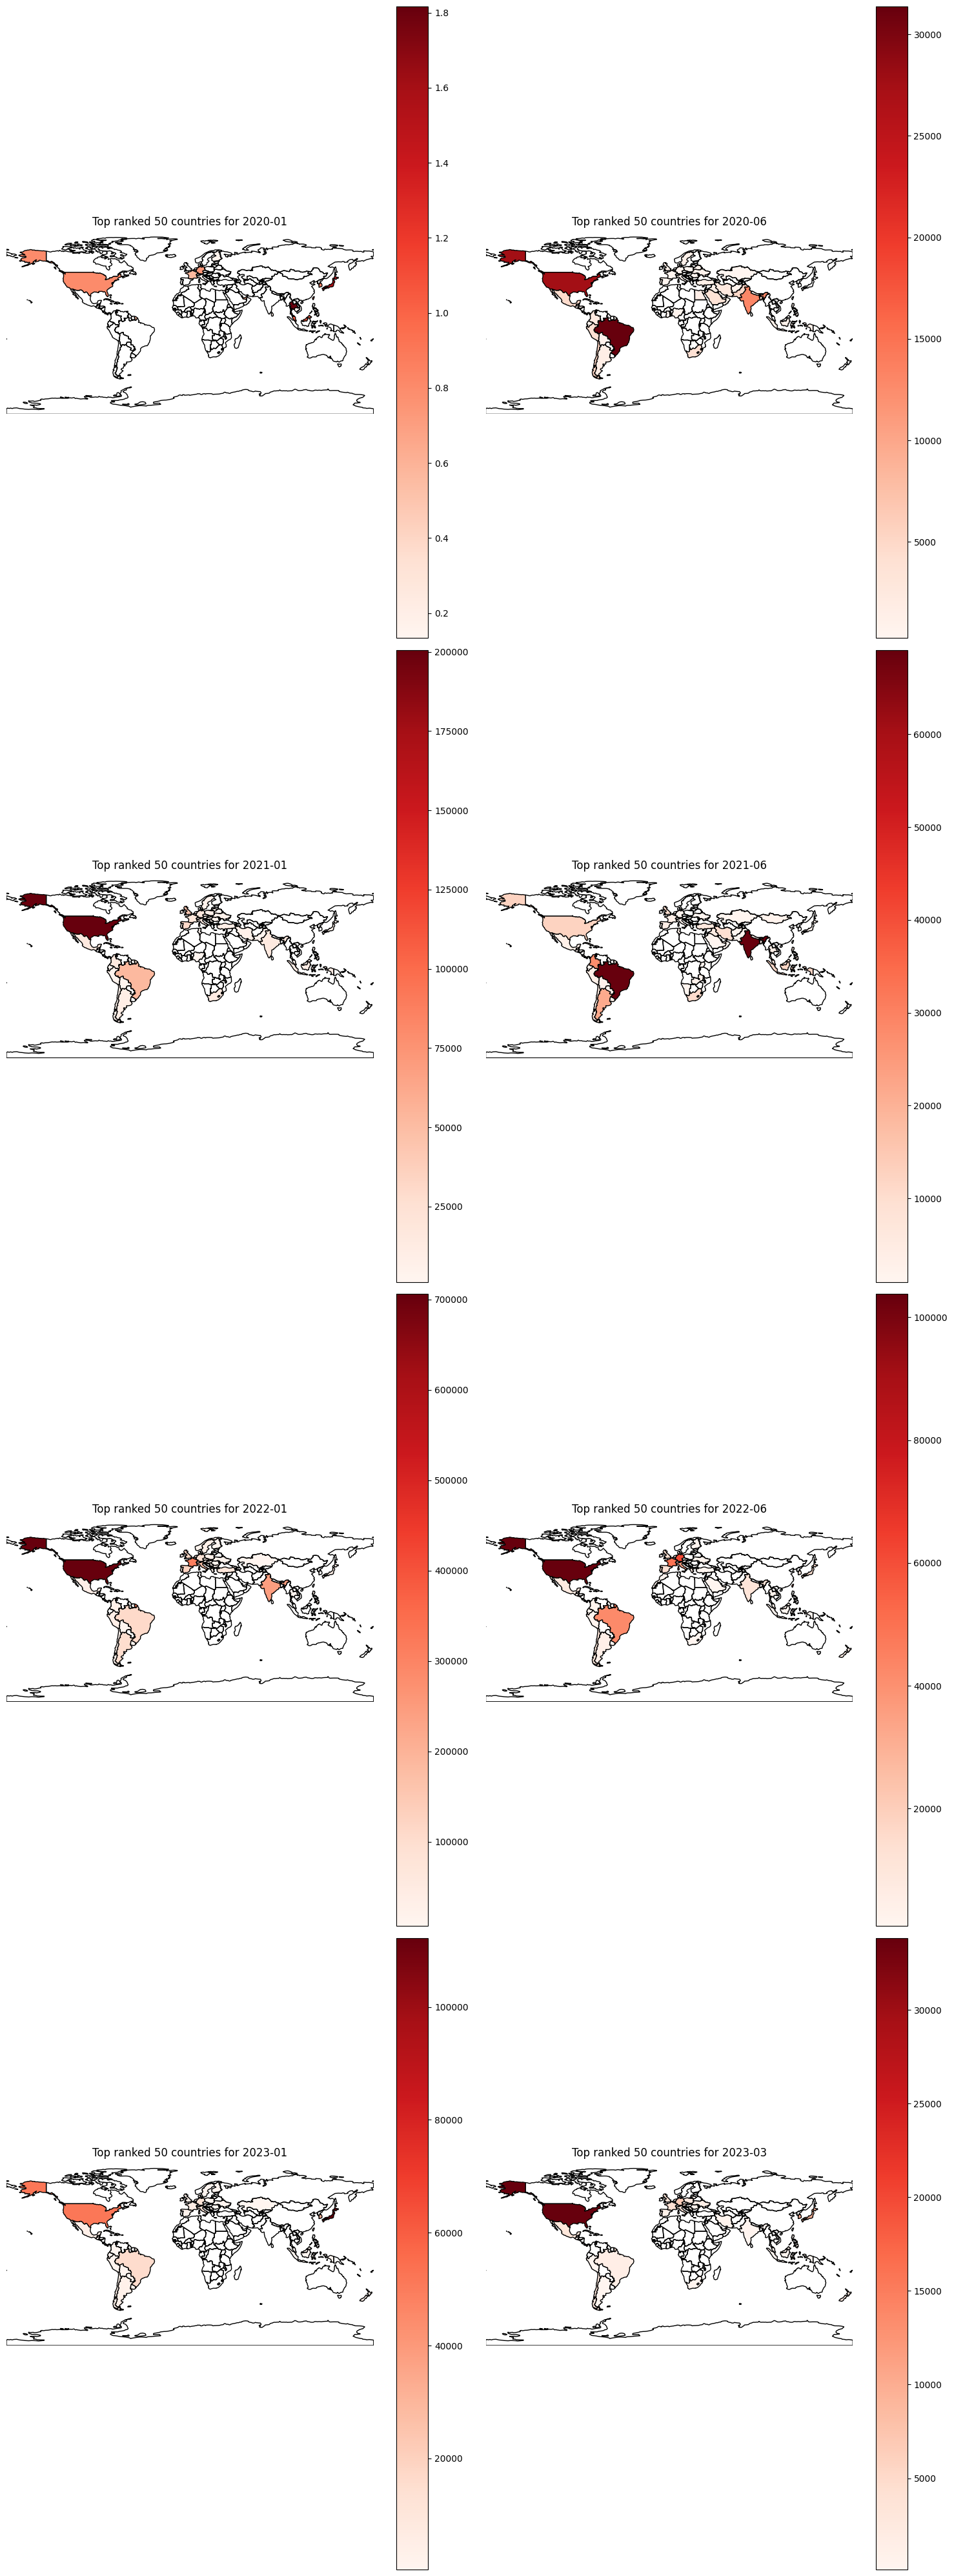

In [74]:
# Import the data
Top_50  = pd.read_csv('data/top_50_State.csv')

# Create a new 'Year-Month' column to respect the format of the dataframe in the file 'top_50_State.csv'
Top_50['Year-Month'] = Top_50['Year'].astype(str) + '-' + Top_50['Month'].astype(str).str.zfill(2)

# Load world map geometries into a GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.explode()

# List of random chosen months to analyze
months = ['2020-01', '2020-06', '2021-01', '2021-06', '2022-01', '2022-06', '2023-01', '2023-03']

# Create a figure for the plots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 40))  

for i, month in enumerate(months):
    # Determine the subplot row and column
    row, col = divmod(i, 2)

    # Select the top 50 countries/States for the given month
    month_df = Top_50[Top_50['Year-Month'] == month].head(50)

    # Select the countries/States common between the world map and the month DataFrame
    merged_data = world.set_index('name').join(month_df.set_index('State/Region'))

    # Plotting the choropleth map with a legend for the month
    ax = gplt.choropleth(
        merged_data, hue='Trendline_Coefficient',
        cmap='Reds', ax=axs[row, col],
        legend=True,  
        norm=Normalize(vmin=merged_data['Trendline_Coefficient'].min(), vmax=merged_data['Trendline_Coefficient'].max())
    )
    ax.set_title(f'Top ranked 50 countries for {month}')

# Show the plot
plt.tight_layout()
plt.show()


Create a Scatter Heat Plot to visualize the density of the countries around the clusters for the top 50 countries/states for each month 

In [75]:

task3_df = pd.read_csv('data/Task3_df.csv')  

# Select the months to analyze randomly
months_selected = ['2020-3', '2020-9', '2021-3', '2021-10', '2022-5', '2022-9', '2023-1', '2023-3']

# Filtering the data for the updated months to analyze
filtered_data = task3_df[task3_df['Year-Month'].isin(months_selected)]

# Creating an interactive scatter plot
fig = px.scatter(filtered_data, x="Trendline_Coefficient", y="State/Region",
                 color="prediction", hover_name="State/Region",
                 facet_col="Year-Month", facet_col_wrap=2,
                 title="States/Regions Clustering by Month",
                 labels={"prediction": "Cluster", "Trendline_Coefficient": "Trendline Coefficient"})

# Adjust layout
fig.update_layout(height=800, hovermode='closest')

# Show the plot
fig.show()

Visualization_time:  23.34677004814148 seconds


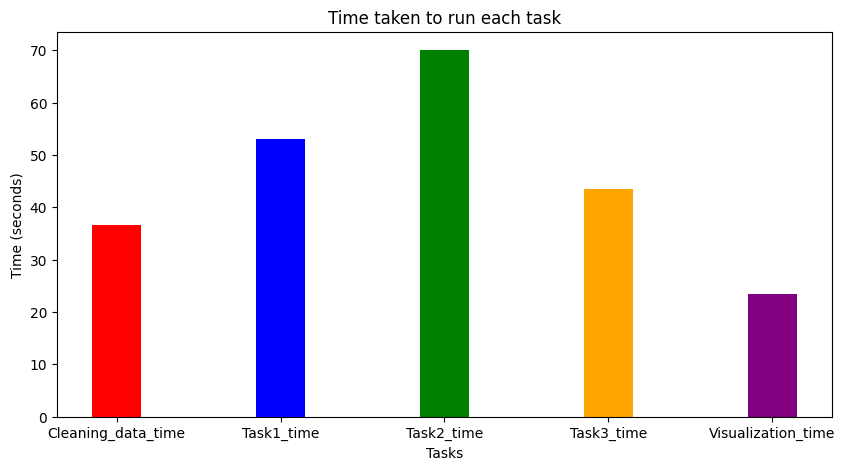

In [76]:
# calculate the time it took to run the code of the visualization of the results
Visualization_time = time.time() - Task3_time - Task2_time - Task1_time - Cleaning_data_time- Debute
# print the duration
print("Visualization_time: ", Visualization_time , "seconds")

# plot the time it took to run each task in a bar chart
plt.figure(figsize=(10, 5))
plt.bar(['Cleaning_data_time', 'Task1_time', 'Task2_time', 'Task3_time', 'Visualization_time'], [Cleaning_data_time, Task1_time, Task2_time, Task3_time, Visualization_time], color=['red', 'blue', 'green', 'orange', 'purple'], width=0.3)
plt.xlabel('Tasks')
plt.ylabel('Time (seconds)')
plt.title('Time taken to run each task')
plt.show()